In [647]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler


In [648]:
energy = pd.read_csv('../../data/origin/energy.csv')
dj_fcst = pd.read_csv('./dj_fcst.csv')
us_fcst = pd.read_csv('./us_fcst.csv')
us_fcst

,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud,일사,일조
0,2018-03-01 11:00:00,4.0,8.0,20.0,14.0,298.0,2.0,0.0,0.983333
1,2018-03-01 11:00:00,7.0,4.0,20.0,4.3,298.0,2.0,0.0,0.983333
2,2018-03-01 11:00:00,10.0,3.0,30.0,1.9,309.0,2.0,0.0,0.983333
3,2018-03-01 11:00:00,13.0,0.0,40.0,1.5,318.0,2.0,0.0,0.983333
4,2018-03-01 11:00:00,16.0,-1.0,45.0,1.8,308.0,2.0,0.0,0.983333
...,...,...,...,...,...,...,...,...,...
162203,2021-03-01 08:00:00,52.0,9.0,45.0,3.1,83.0,3.0,0.0,0.000000
162204,2021-03-01 08:00:00,55.0,9.0,45.0,3.0,111.0,3.0,0.0,0.000000
162205,2021-03-01 08:00:00,58.0,8.0,55.0,2.2,122.0,3.0,0.0,0.000000
162206,2021-03-01 08:00:00,61.0,6.0,65.0,0.9,131.0,3.0,0.0,0.000000


In [649]:
dj_fcst['Forecast_time'] = pd.to_datetime(dj_fcst['Forecast time'])
us_fcst['Forecast_time'] = pd.to_datetime(us_fcst['Forecast time'])

In [650]:
dj_fcst_14 = dj_fcst[dj_fcst['Forecast_time'].dt.hour==11]
us_fcst_14 = us_fcst[us_fcst['Forecast_time'].dt.hour==23]
dj_fcst_14.head(2)

,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud,일사,일조,Forecast_time
0,2018-03-01 11:00:00,4.0,0.0,60.0,7.3,309.0,2.0,2.54,0.983333,2018-03-01 11:00:00
1,2018-03-01 11:00:00,7.0,-2.0,60.0,7.1,314.0,1.0,2.54,0.983333,2018-03-01 11:00:00


In [651]:
dj_fcst_14 = dj_fcst_14[(dj_fcst_14['forecast']>=13)&(dj_fcst_14['forecast']<=36)]
dj_fcst_14.head()

,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud,일사,일조,Forecast_time
3,2018-03-01 11:00:00,13.0,-2.0,55.0,6.7,336.0,1.0,2.54,0.983333,2018-03-01 11:00:00
4,2018-03-01 11:00:00,16.0,-4.0,55.0,5.5,339.0,1.0,2.54,0.983333,2018-03-01 11:00:00
5,2018-03-01 11:00:00,19.0,-5.0,60.0,4.3,344.0,1.0,2.54,0.983333,2018-03-01 11:00:00
6,2018-03-01 11:00:00,22.0,-2.0,55.0,2.0,345.0,1.0,2.54,0.983333,2018-03-01 11:00:00
7,2018-03-01 11:00:00,25.0,1.0,45.0,0.8,256.0,1.0,2.54,0.983333,2018-03-01 11:00:00


In [652]:
us_fcst_14 = us_fcst_14[(us_fcst_14['forecast']>=1)&(us_fcst_14['forecast']<=24)]
us_fcst_14.head()

,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud,일사,일조,Forecast_time
74,2018-03-01 23:00:00,4.0,-1.0,45.0,1.8,299.0,2.0,0.0,0.0,2018-03-01 23:00:00
75,2018-03-01 23:00:00,7.0,-1.0,45.0,1.8,304.0,1.0,0.0,0.0,2018-03-01 23:00:00
76,2018-03-01 23:00:00,10.0,0.0,35.0,1.6,320.0,1.0,0.0,0.0,2018-03-01 23:00:00
77,2018-03-01 23:00:00,13.0,6.0,25.0,1.4,326.0,1.0,0.0,0.0,2018-03-01 23:00:00
78,2018-03-01 23:00:00,16.0,9.0,30.0,0.4,104.0,1.0,0.0,0.0,2018-03-01 23:00:00


In [653]:
def to_date(x):
    return pd.DateOffset(hours=x)

dj_fcst_14['Forecast_time'] = dj_fcst_14['Forecast_time'] + dj_fcst_14['forecast'].map(to_date)
us_fcst_14['Forecast_time'] = us_fcst_14['Forecast_time'] + us_fcst_14['forecast'].map(to_date)

D:\anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1342: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  warnings.warn(


In [654]:
dj_fcst_14 = dj_fcst_14[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud', '일사', '일조']]
us_fcst_14 = us_fcst_14[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud', '일사', '일조']]
us_fcst_14

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud,일사,일조
74,2018-03-02 03:00:00,-1.0,45.0,1.8,299.0,2.0,0.0,0.0
75,2018-03-02 06:00:00,-1.0,45.0,1.8,304.0,1.0,0.0,0.0
76,2018-03-02 09:00:00,0.0,35.0,1.6,320.0,1.0,0.0,0.0
77,2018-03-02 12:00:00,6.0,25.0,1.4,326.0,1.0,0.0,0.0
78,2018-03-02 15:00:00,9.0,30.0,0.4,104.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
162136,2021-03-01 09:00:00,15.0,80.0,4.1,155.0,4.0,0.0,0.0
162137,2021-03-01 12:00:00,17.0,70.0,5.2,173.0,4.0,0.0,0.0
162138,2021-03-01 15:00:00,17.0,75.0,5.2,179.0,4.0,0.0,0.0
162139,2021-03-01 18:00:00,17.0,80.0,7.3,187.0,4.0,0.0,0.0


In [655]:
dj_fcst_14_ = pd.DataFrame()
dj_fcst_14_['Forecast_time'] = pd.date_range(start='2018-03-02 00:00:00', end='2021-03-01 23:00:00', freq='H')

us_fcst_14_ = pd.DataFrame()
us_fcst_14_['Forecast_time'] = pd.date_range(start='2018-03-02 00:00:00', end='2021-03-01 23:00:00', freq='H')
dj_fcst_14_.head()

,Forecast_time
0,2018-03-02 00:00:00
1,2018-03-02 01:00:00
2,2018-03-02 02:00:00
3,2018-03-02 03:00:00
4,2018-03-02 04:00:00


In [656]:
dj_fcst_14_ = pd.merge(dj_fcst_14_, dj_fcst_14, on='Forecast_time', how='outer')
us_fcst_14_ = pd.merge(us_fcst_14_, us_fcst_14, on='Forecast_time', how='outer')
dj_fcst_14

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud,일사,일조
3,2018-03-02 00:00:00,-2.0,55.0,6.7,336.0,1.0,2.54,0.983333
4,2018-03-02 03:00:00,-4.0,55.0,5.5,339.0,1.0,2.54,0.983333
5,2018-03-02 06:00:00,-5.0,60.0,4.3,344.0,1.0,2.54,0.983333
6,2018-03-02 09:00:00,-2.0,55.0,2.0,345.0,1.0,2.54,0.983333
7,2018-03-02 12:00:00,1.0,45.0,0.8,256.0,1.0,2.54,0.983333
...,...,...,...,...,...,...,...,...
162066,2021-03-01 09:00:00,8.0,90.0,3.9,64.0,4.0,1.00,0.066667
162067,2021-03-01 12:00:00,10.0,90.0,4.8,7.0,4.0,1.00,0.066667
162068,2021-03-01 15:00:00,10.0,85.0,6.6,11.0,4.0,1.00,0.066667
162069,2021-03-01 18:00:00,7.0,85.0,6.5,34.0,4.0,1.00,0.066667


In [657]:
dj_fcst = dj_fcst_14_.interpolate()
us_fcst = us_fcst_14_.interpolate()
dj_fcst

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud,일사,일조
0,2018-03-02 00:00:00,-2.000000,55.000000,6.7,336.000000,1.0,2.54,0.983333
1,2018-03-02 01:00:00,-2.666667,55.000000,6.3,337.000000,1.0,2.54,0.983333
2,2018-03-02 02:00:00,-3.333333,55.000000,5.9,338.000000,1.0,2.54,0.983333
3,2018-03-02 03:00:00,-4.000000,55.000000,5.5,339.000000,1.0,2.54,0.983333
4,2018-03-02 04:00:00,-4.333333,56.666667,5.1,340.666667,1.0,2.54,0.983333
...,...,...,...,...,...,...,...,...
26299,2021-03-01 19:00:00,6.333333,85.000000,6.3,31.666667,4.0,1.00,0.066667
26300,2021-03-01 20:00:00,5.666667,85.000000,6.1,29.333333,4.0,1.00,0.066667
26301,2021-03-01 21:00:00,5.000000,85.000000,5.9,27.000000,4.0,1.00,0.066667
26302,2021-03-01 22:00:00,5.000000,85.000000,5.9,27.000000,4.0,1.00,0.066667


In [658]:
dj_fcst['Forecast_time'] = dj_fcst['Forecast_time'].astype(str)
us_fcst['Forecast_time'] = us_fcst['Forecast_time'].astype(str)
dj_fcst

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud,일사,일조
0,2018-03-02 00:00:00,-2.000000,55.000000,6.7,336.000000,1.0,2.54,0.983333
1,2018-03-02 01:00:00,-2.666667,55.000000,6.3,337.000000,1.0,2.54,0.983333
2,2018-03-02 02:00:00,-3.333333,55.000000,5.9,338.000000,1.0,2.54,0.983333
3,2018-03-02 03:00:00,-4.000000,55.000000,5.5,339.000000,1.0,2.54,0.983333
4,2018-03-02 04:00:00,-4.333333,56.666667,5.1,340.666667,1.0,2.54,0.983333
...,...,...,...,...,...,...,...,...
26299,2021-03-01 19:00:00,6.333333,85.000000,6.3,31.666667,4.0,1.00,0.066667
26300,2021-03-01 20:00:00,5.666667,85.000000,6.1,29.333333,4.0,1.00,0.066667
26301,2021-03-01 21:00:00,5.000000,85.000000,5.9,27.000000,4.0,1.00,0.066667
26302,2021-03-01 22:00:00,5.000000,85.000000,5.9,27.000000,4.0,1.00,0.066667


In [659]:
def train_datast(energy_df, fcst_df, target):
    # 일기 예보 있는 날짜만 선택
    energy = energy_df.loc[24:]
    energy.index = range(energy.shape[0])
    
    # 발전량 데이터가 있는 날짜만 선택
    fcst = fcst_df.loc[:25608-1]
    fcst.index = range(fcst.shape[0])
    
    # 발전량과 일기예보 연결
    concat_df = pd.concat([energy, fcst], axis=1)
    
    # 예보 시간 및 날짜 정보 feature로 추가
    concat_df['date'] = concat_df['Forecast_time'].str.split(' ').str[0]
    concat_df['hour'] = concat_df['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)
    
    concat_df['year'] = concat_df['date'].str.split('-').str[0].astype(int)
    concat_df['month'] = concat_df['date'].str.split('-').str[1].astype(int)
    concat_df['day'] = concat_df['date'].str.split('-').str[2].astype(int)
    
    # 예보 시간, 날짜, 기상 예보 및 발전량 선택
    feature_df = concat_df[['year', 'month', 'day', 'hour', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud', '일사', '일조', target]]
    
    # 마지막 30일을 검증데이터셋으로 나머지를 학습 데이터셋으로 선택
    train_df = feature_df.iloc[:-24*30]
    val_df = feature_df.iloc[-24*30:]
    
    # 발전량이 0인 데이터를 제외
    train_df = train_df[train_df[target]!=0]
    
    train_x = train_df.loc[:, 'year':'일조'].to_numpy()
    train_y = train_df[target].to_numpy()
    
    val_x = val_df.loc[:, 'year':'일조'].to_numpy()
    val_y = val_df[target].to_numpy()
    
    return train_x, train_y, val_x, val_y

In [660]:
def nmae_10(y_pred, dataset):
    y_true = dataset.get_label()
    
    absolute_error = abs(y_true - y_pred)
    absolute_error /= capacity
    
    target_idx = np.where(y_true>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return 'score', nmae, False

In [661]:
def sola_nmae(answer, pred):
    absolute_error = np.abs(answer - pred)
    
    absolute_error /= capacity
    
    target_idx = np.where(answer>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return nmae

In [662]:
params = {
    'learning_rate': 0.031,
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

In [663]:
train_x, train_y, val_x, val_y = train_datast(energy, dj_fcst, target='dangjin_floating')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 1000
dangjin_floating_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1076
[LightGBM] [Info] Number of data points in the train set: 12378, number of used features: 11
[LightGBM] [Info] Start training from score 247.345048
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[86]	valid_0's l1: 63.2402	valid_0's score: 8.04561


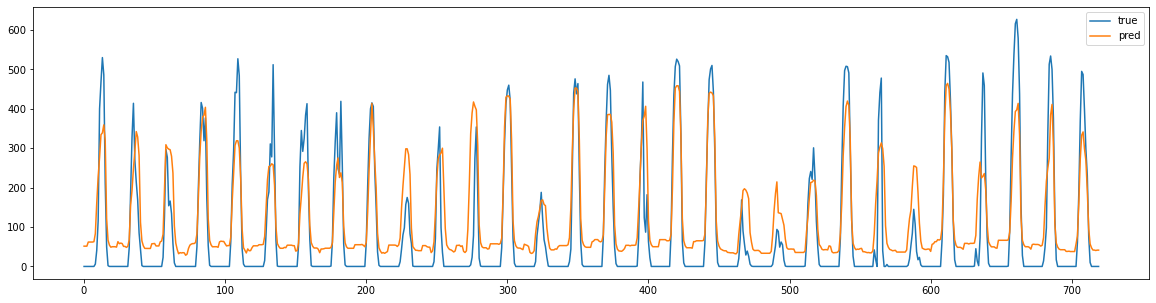

CV Score :  8.045608898564307


In [664]:
pred = dangjin_floating_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

In [665]:
train_x, train_y, val_x, val_y = train_datast(energy, dj_fcst, target='dangjin_warehouse')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 700
dangjin_warehouse_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1078
[LightGBM] [Info] Number of data points in the train set: 11949, number of used features: 11
[LightGBM] [Info] Start training from score 193.765671
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[224]	valid_0's l1: 32.1383	valid_0's score: 9.16925


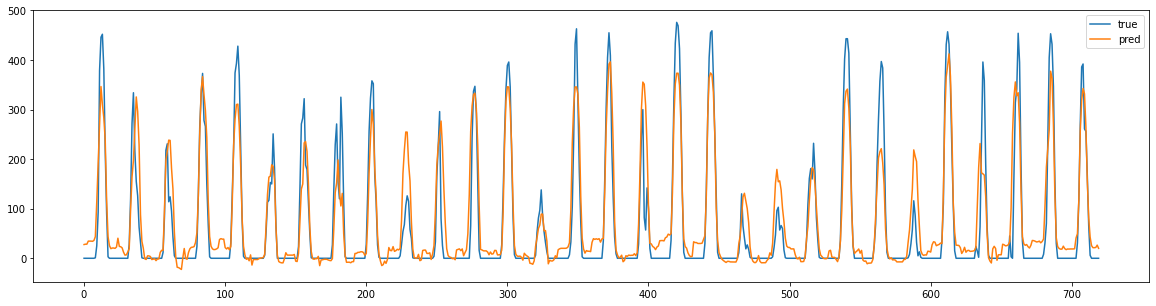

CV Score :  9.169245871692823


In [666]:
pred = dangjin_warehouse_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

In [667]:
train_x, train_y, val_x, val_y = train_datast(energy, dj_fcst, target='dangjin')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 1000
dangjin_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1073
[LightGBM] [Info] Number of data points in the train set: 11349, number of used features: 11
[LightGBM] [Info] Start training from score 308.414486
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[229]	valid_0's l1: 46.1817	valid_0's score: 9.60621


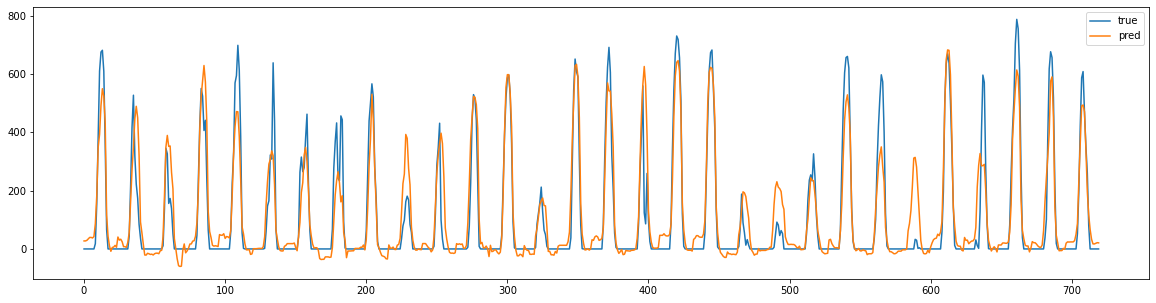

CV Score :  9.606210945706897


In [668]:
pred = dangjin_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

In [669]:
train_x, train_y, val_x, val_y = train_datast(energy, us_fcst, target='ulsan')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 500
ulsan_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 749
[LightGBM] [Info] Number of data points in the train set: 11811, number of used features: 9
[LightGBM] [Info] Start training from score 135.559394
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[222]	valid_0's l1: 14.2231	valid_0's score: 6.14344


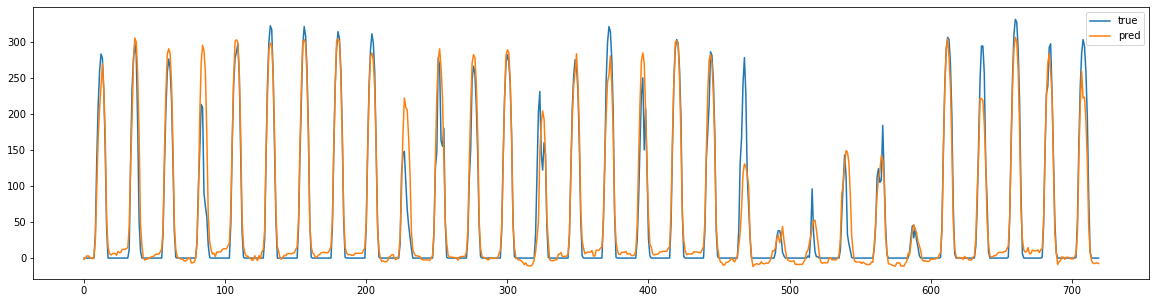

CV Score :  6.143436806507421


In [670]:
pred = ulsan_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

In [671]:
def test_datast(fcst_df):
    start = '2021-02-01 00:00:00'
    end = '2021-02-28 23:00:00'
    
    start_idx = fcst_df[fcst_df['Forecast_time']==start].index[0]
    end_idx = fcst_df[fcst_df['Forecast_time']==end].index[0]
    
    test_df = fcst_df.loc[start_idx:end_idx, :].copy()
    
    test_df['date'] = test_df['Forecast_time'].str.split(' ').str[0]
    test_df['hour'] = test_df['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)
    
    test_df['year'] = test_df['date'].str.split('-').str[0].astype(int)
    test_df['month'] = test_df['date'].str.split('-').str[1].astype(int)
    test_df['day'] = test_df['date'].str.split('-').str[2].astype(int)
    
    test_df = test_df[['year', 'month', 'day', 'hour', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud', '일사', '일조']]
    
    test_x = test_df.to_numpy()
    
    return test_x

In [672]:
dangjin_test = test_datast(dj_fcst)

In [673]:
ulsan_test = test_datast(us_fcst)


In [674]:
dangjin_floating_pred = dangjin_floating_model.predict(dangjin_test)
dangjin_warehouse_pred = dangjin_warehouse_model.predict(dangjin_test)
dangjin_pred = dangjin_model.predict(dangjin_test)

In [675]:
ulsan_pred = ulsan_model.predict(ulsan_test)


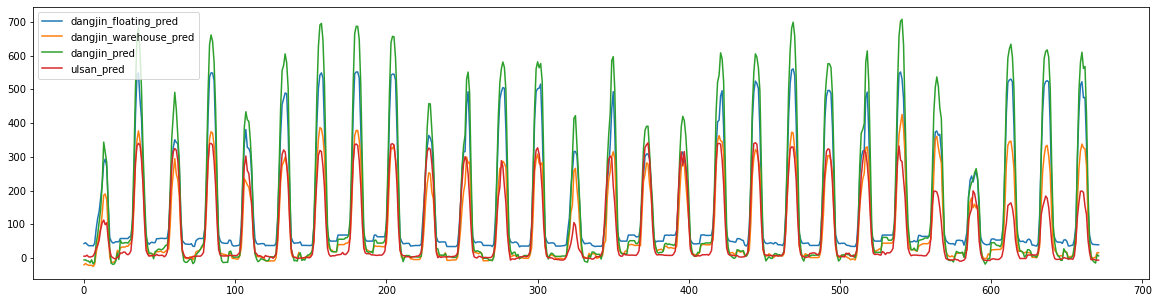

In [676]:
plt.figure(figsize=(20,5))
plt.plot(dangjin_floating_pred, label = 'dangjin_floating_pred')
plt.plot(dangjin_warehouse_pred, label = 'dangjin_warehouse_pred')
plt.plot(dangjin_pred, label = 'dangjin_pred')
plt.plot(ulsan_pred, label = 'ulsan_pred')
plt.legend()
plt.show()

In [677]:
submission = pd.read_csv('../../data/origin/sample_submission.csv')
submission.head()

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2021-02-01 01:00:00,0,0,0,0
1,2021-02-01 02:00:00,0,0,0,0
2,2021-02-01 03:00:00,0,0,0,0
3,2021-02-01 04:00:00,0,0,0,0
4,2021-02-01 05:00:00,0,0,0,0


In [678]:
submission.iloc[:24*28, 1] = dangjin_floating_pred
submission.iloc[:24*28, 2] = dangjin_warehouse_pred
submission.iloc[:24*28, 3] = dangjin_pred
submission.iloc[:24*28, 4] = ulsan_pred

In [679]:
submission

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2021-02-01 01:00:00,42.839835,-20.052181,-5.748795,5.377632
1,2021-02-01 02:00:00,45.202977,-16.181499,-5.399790,5.377632
2,2021-02-01 03:00:00,40.656790,-19.681191,-8.496173,8.326314
3,2021-02-01 04:00:00,36.505024,-21.594812,-9.098172,3.641464
4,2021-02-01 05:00:00,36.505024,-21.714161,-14.222907,2.577595
...,...,...,...,...,...
1387,2021-07-08 20:00:00,0.000000,0.000000,0.000000,0.000000
1388,2021-07-08 21:00:00,0.000000,0.000000,0.000000,0.000000
1389,2021-07-08 22:00:00,0.000000,0.000000,0.000000,0.000000
1390,2021-07-08 23:00:00,0.000000,0.000000,0.000000,0.000000


In [680]:
submission.to_csv('dacon_baseline.csv', index=False)